In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import glob
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
from preprocess_data import read_json, read_image_strings
import matplotlib.pyplot as plt

In [2]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
NUM_IMAGES = 1000

TRAIN_PATH = 'data/train_set/'
TEST_PATH = 'data/test_set/'

In [48]:
data_train = read_json(TRAIN_PATH,'label_data_*.json')
data_test = read_json(TEST_PATH,'test_label.json')

train_paths = glob.glob(TRAIN_PATH + 'labelled/images/*.png')
train_paths.sort()
train_labels = glob.glob(TRAIN_PATH + 'labelled/labels/*.png')
train_labels.sort()
test_paths = glob.glob(TEST_PATH + 'labelled/images/*.png')
test_paths.sort()
test_labels = glob.glob(TEST_PATH + 'labelled/labels/*.png')
test_labels.sort()

X_train = np.zeros((len(train_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_labels), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


['data/train_set/label_data_0531.json', 'data/train_set/label_data_0313.json', 'data/train_set/label_data_0601.json']
Number of labeled images: 3626
data keys: dict_keys(['lanes', 'h_samples', 'raw_file'])
['data/test_set/test_label.json']
Number of labeled images: 2782
data keys: dict_keys(['lanes', 'h_samples', 'raw_file'])


Load images and masks in order so they match

In [48]:
print(train_labels[0])

data/train_set/labelled/labels/0000.png


In [4]:
print('Resizing training images and masks')

for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):   
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

Resizing training images and masks


100%|██████████| 3626/3626 [09:16<00:00,  6.51it/s]


In [5]:
 for n, path in tqdm(enumerate(train_labels), total=len(train_labels)):
    mask = imread(path)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                  preserve_range=True), axis=-1)  
        
    Y_train[n] = mask 

100%|██████████| 3626/3626 [02:41<00:00, 22.45it/s]


In [6]:
# test images
X_test = np.zeros((len(test_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 2782/2782 [07:07<00:00,  6.51it/s]

Done!


In [49]:
Y_test = np.zeros((len(test_labels), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, path in tqdm(enumerate(test_labels), total=len(test_labels)):
    mask = imread(path)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                  preserve_range=True), axis=-1)  
        
    Y_test[n] = mask 

100%|██████████| 2782/2782 [01:49<00:00, 25.50it/s]


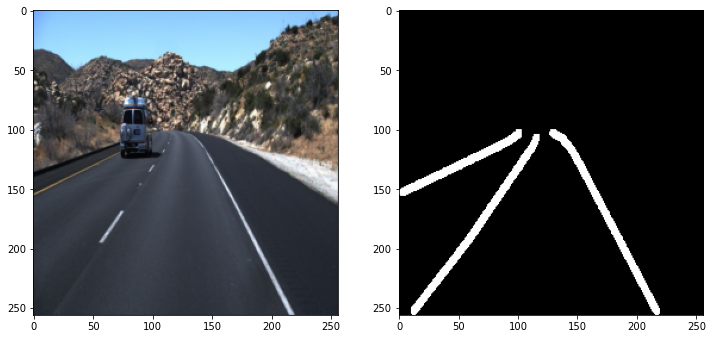

In [9]:
# Visualize random image and label
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(Y_train[image_number], cmap='gray')
plt.show()

In [10]:
def unet(input_shape):

    #Build the model
    inputs = tf.keras.layers.Input(input_shape)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [11]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-03-25 19:59:54.811316: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 19:59:57.656703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4093 MB memory:  -> device: 0, name: Tesla K20m, pci bus id: 0000:02:00.0, compute capability: 3.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_tusimple.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'), checkpointer]

2022-03-25 20:00:05.995039: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 20:00:05.995082: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-25 20:00:05.999889: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-25 20:00:06.277027: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 20:00:06.280080: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [13]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

2022-03-25 20:00:19.299972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-03-25 20:00:22.688396: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-03-25 20:00:24.956690: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-25 20:00:24.957561: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-25 20:00:24.957593: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-25 20:00:24.958120: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-25 20:00:24.958204: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  1/204 [..............................] - ETA: 1:06:12 - loss: 0.5861 - accuracy: 0.9030

2022-03-25 20:00:38.994272: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 20:00:38.994318: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/204 [..............................] - ETA: 3:48 - loss: 0.4524 - accuracy: 0.9214   

2022-03-25 20:00:40.092740: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-25 20:00:40.098717: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-25 20:00:40.167534: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2610 callback api events and 2607 activity events. 
2022-03-25 20:00:40.212245: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 20:00:40.301889: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_03_25_20_00_40

2022-03-25 20:00:40.356757: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_25_20_00_40/c0605.crane.hcc.unl.edu.trace.json.gz
2022-03-25 20:00:40.430136: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: lo

204/204 [==============================] - 115s 469ms/step - loss: 0.2369 - accuracy: 0.9387 - val_loss: 0.1719 - val_accuracy: 0.9299
Epoch 2/25
204/204 [==============================] - 81s 396ms/step - loss: 0.1116 - accuracy: 0.9538 - val_loss: 0.1121 - val_accuracy: 0.9575
Epoch 3/25
204/204 [==============================] - 81s 396ms/step - loss: 0.0734 - accuracy: 0.9686 - val_loss: 0.1041 - val_accuracy: 0.9626
Epoch 4/25
204/204 [==============================] - 81s 396ms/step - loss: 0.0640 - accuracy: 0.9726 - val_loss: 0.1076 - val_accuracy: 0.9660
Epoch 5/25
204/204 [==============================] - 81s 396ms/step - loss: 0.0588 - accuracy: 0.9748 - val_loss: 0.1020 - val_accuracy: 0.9670
Epoch 6/25
204/204 [==============================] - 81s 396ms/step - loss: 0.0560 - accuracy: 0.9759 - val_loss: 0.1082 - val_accuracy: 0.9674
Epoch 7/25
204/204 [==============================] - 81s 396ms/step - loss: 0.0533 - accuracy: 0.9770 - val_loss: 0.1010 - val_accuracy: 0.

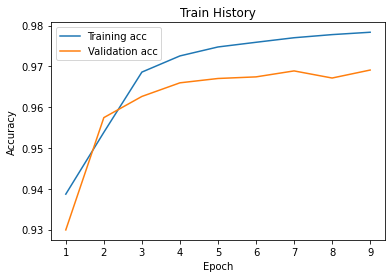

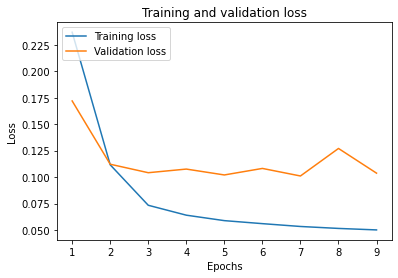

In [19]:
#plot the training and validation accuracy and loss at each epoch
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, results.history['accuracy'])
plt.plot(epochs, results.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training acc', 'Validation acc'], loc='upper left')
plt.show()

# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

loss = results.history['loss']
val_loss = results.history['val_loss']
plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

In [20]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
# ix = random.randint(0, len(preds_train_t))
# imshow(X_train[ix])
# plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
# imshow(np.squeeze(preds_train_t[ix]))
# plt.show()

86/87 [============================>.] - ETA: 0s

2022-03-25 20:24:18.086048: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


87/87 [==============================] - 23s 263ms/step


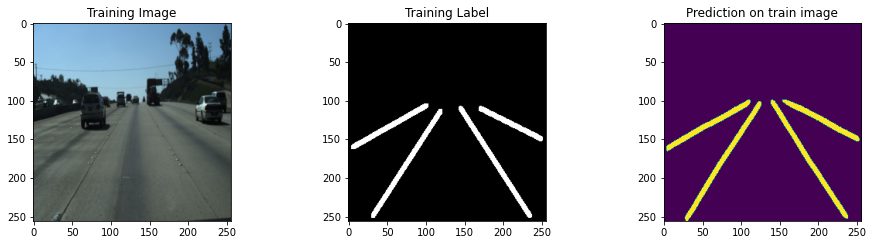

In [45]:
# Perform a sanity check on some random train samples
ix = random.randint(0, len(preds_train_t))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(X_train[ix])
plt.subplot(232)
plt.title('Training Label')
plt.imshow(Y_train[ix][:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(preds_train_t[ix])

plt.show()

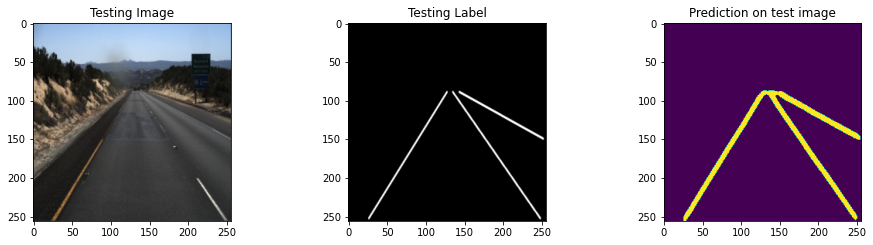

In [53]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(X_test[ix])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(Y_test[ix][:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(preds_test_t[ix])


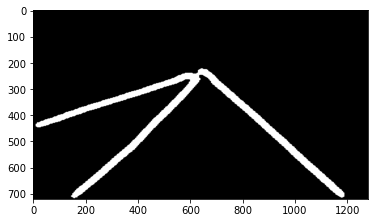

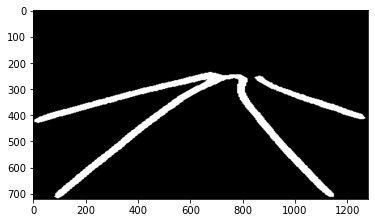

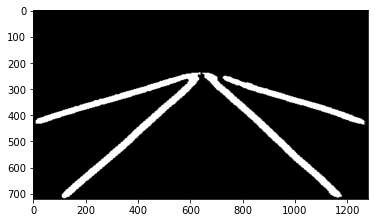

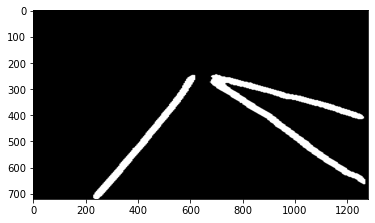

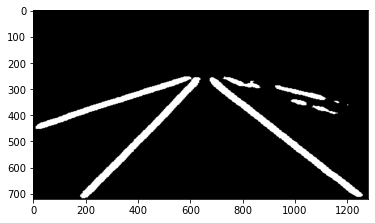

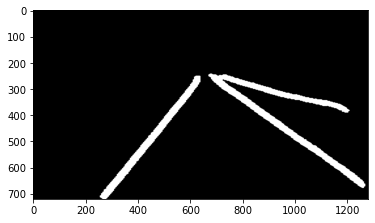

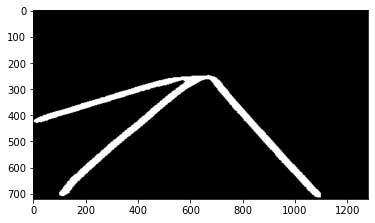

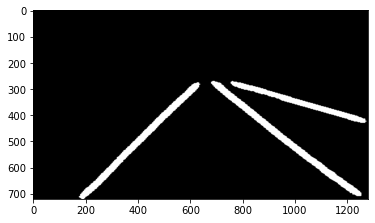

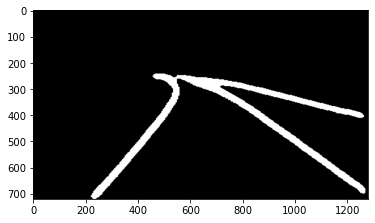

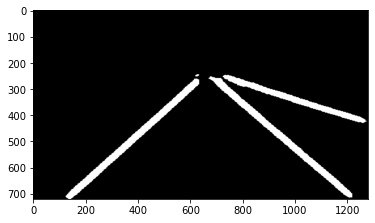

In [59]:
import cv2
# Save a few sample images
nums = random.sample(range(len(X_test)), 10)
for i in nums:
    test_img = X_test[i]
    ground_truth=Y_test[i]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    orig = cv2.resize(test_img, dsize=(1280, 720), interpolation=cv2.INTER_CUBIC)  
    res = cv2.resize(prediction, dsize=(1280, 720), interpolation=cv2.INTER_CUBIC)
    plt.imshow(res, cmap='gray')
    plt.imsave(os.path.join(os.getcwd(), f'predictions/pred_image_{i}.png'), res, cmap='gray')
    plt.show()
    